# BL EThOS
#### Katriona Goldmann, November 2022

---

# Intro

The British Library operates its [Electronic Theses Online Service](https://ethos.bl.uk) or EThOS, that keeps track of PhD theses accepted at UK higher education institutions. The Library also makes public a [data set](https://data.bl.uk/ethos/) of metadata for all theses in their catalogue. Quoting their website,

>The EThOS dataset lists virtually all UK doctoral theses ever awarded, some 500,000 dating back to 1787. All UK HE institutions are included, but we estimate records are missing for around 10,000 titles (2%).

The latest version of the dataset is from October 2022. The data includes the title, year, author, institution, discipline for each thesis, as well as a link to a full record which may or may not include things like keywords or access to full texts.

---

## Analysis goals and outline 

In this notebook I explore this EThOS dataset to identify gender trends in UK academia. The notebook is structured roughly as follows:
- [x] Prepare the data for analysis

#### Gender analysis
- [x] Predict the gender of authors from their first name
- [ ] Predict supervisor genders

#### Buzz words
- [ ] Study trends in the popularities of individual words appearing in thesis titles
- [ ] Use a co-occurrence graph of words in thesis titles to detect academic fields, and score thesis titles on which field(s) they seem to belong to
- [ ] Use the above to study trends in the popularity of different academic fields

---

# 0. Setting up and preparing the data

## 0.1 Load in the data and import packages

First off, some imports of python libraries we'll be needing, and loading the data file into a pandas DataFrame. The script will automatically download the data file into the current working directory if it isn't there yet.

In [ ]:
import os
import operator as opr
import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx
import re
import gender_guesser.detector as gender
import community  # Network community finding
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go



from IPython.display import set_matplotlib_formats

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]

# Set a consistent plotting style across the notebook using Seaborn.
sns.set_style("darkgrid")
sns.set_context("notebook")

Get the data from EThOS. The latest one which isn't embargoed in 202210. 

In [ ]:
# Function to clean the NaN and incorrectly formatted data
def remove_na(df: pd.DataFrame, save: bool = True,
              filename: str = "Data/EThOS_CSV_202210.csv") -> pd.DataFrame:
    null_df = df[df["IR URL"].isnull()]
    for index, row in null_df.iterrows():
        new_row = []
        # Title
        new_row.append(row["Title"].split(",")[0])
        # DOI
        new_row.append(row["Title"].split(",")[1])
        # Author
        first_name = row["Title"].split(",")[2]
        second_name = row["DOI"][:-1]
        new_row.append(first_name + second_name)
        # Remaining columns
        colnames = [col for col in df.columns
                    if col not in ["Title", "DOI", "IR URL"]]
        new_row += row[colnames].tolist()
        df.loc[index] = new_row
    df = df.fillna(' ')
    if save:
        df.to_csv(f"cleaned_{filename}")
    return 

In [ ]:
datafile = "EThOS_CSV_202304.csv"

print('../Data/' + datafile)

import os
os.getcwd()

In [ ]:
# Check if file not already downloaded
if not os.path.isfile('../Data/' + datafile):
    # Download and/or unzip the data file from the EThOS website.
    # We need a couple more imports for this.
    import zipfile

    datazip = re.sub("csv", "zip", datafile)
    if not os.path.isfile('../Data/' + datazip):
        import requests

        dataurl = "https://bl.iro.bl.uk/downloads/6c6aab6d-a8e1-4ed7-85e2-7963d2569f80?locale=en"
        with requests.Session() as s:
            headers = {
                "User-agent": "Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0"
            }
            r = s.get(dataurl, headers=headers)
            with open('../Data/' + datazip, "wb") as f:
                f.write(r.content)
    with zipfile.ZipFile('../Data/' + datazip, "r") as z:
        z.extractall(".")

In [ ]:
df = pd.read_csv(f"../Data/cleaned_{datafile}", encoding="ISO-8859-2")

## 0.2 Inspect the data

To get an idea of what the rows in the DataFrame look like, here are some samples:

In [ ]:
df.head()

How many entries are we dealing with?: 

In [ ]:
set(df['Qualification'])

In [ ]:
print(df.shape[0])

Data is loaded...so let's query it and search for the ETHoS contributors:

In [ ]:

df.loc[df['Author'].str.contains('|'.join(['Fenton, I', 'Hauru, M', 'Goldmann, K', 'Chan, Ryan', 'Nanni, F', 'Beavan, D', 'Rangel Smith, C']))]

Most team members either completed doctorates too recently, or outside the UK.

---

#  1. Author Gender Analysis

## 1.1 Extract author names

In [ ]:
# Oragnise names into surname, first name and forenames
df['Surname'] = df.apply(lambda row : row['Author'].split(",")[0].strip(), axis = 1)
df['Forenames'] = df.apply(lambda row : re.sub(".*,", "", str(row['Author'])), axis = 1)
df['Firstname'] = df.apply(lambda row : row['Forenames'].strip().split(" ")[0].strip(), axis = 1)

In [ ]:
df[['Author', 'Surname', 'Firstname', 'Forenames']].head(10)

## 1.1 Predict gender from first name

We will use [gender-guesser](https://pypi.org/project/gender-guesser/) to predict an individuals gender from their first name. This can match data for about 40,000 Names from a database.

Lets test is out on two names we know the gender for, and with a couple of different spellings to really test the system:

In [ ]:
gd = gender.Detector()

list_of_names = [['Katriona', 'Katrina', 'Catriona', 'Caitriona','Catarina', 'Caterina', 'Catrina'], 
                 ['Isabel', 'Isabelle', 'Isobel'],
                ['Ryan']]

print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[0]]), '\n-----')
print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[1]]), '\n-----')
print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[2]]))

In this case it works pretty well - just issues with unusual spellings. 

In [ ]:
df['Predicted_gender'] = df.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)

# replace andy with androgenous in Predicted gender
df['Predicted_gender'] = df['Predicted_gender'].replace({'andy': 'androgynous'})

df['Predicted_gender'] = df['Predicted_gender'].str.capitalize()

gender_count = df.Predicted_gender.value_counts()
print(gender_count)

Visualise these predictions

In [ ]:
colours = {'Unknown': 'grey', 
        'Androgynous': '#4CAF50', 
        'Female': '#730C6D', 
        'Male': '#F4BA3B', 
        'Mostly_female': '#ab65a7', 
        'Mostly_male': '#f5dca6', 
        'Initials': '#76b5c5'
        }




In [ ]:
plt.pie(gender_count, labels = list(gender_count.index), 
        colors =[colours[key] for key in list(gender_count.index)]
)
plt.show() 

And if we repeat this but dropping initialised names? 

In [ ]:
# Remove initialised first names
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in df['Firstname'] ]
df_fullname = df.loc[s]

# Predict gender on _this_
df_fullname['Predicted_gender'] = df_fullname.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
df_fullname['Predicted_gender'] = df_fullname['Predicted_gender'].replace({'andy': 'androgynous'})
df_fullname['Predicted_gender'] = df_fullname['Predicted_gender'].str.capitalize()

gender_count = df_fullname.Predicted_gender.value_counts()

print(gender_count)

plt.pie(gender_count, labels=list(gender_count.index),
        colors=[colours[key] for key in list(gender_count.index)]
)
plt.show() 

If we break this down into those confirmed as male and female only.  

In [ ]:
df_gender = df.loc[df["Predicted_gender"].isin(["Female", "Male"])]

print('We lose', df.shape[0] - df_gender.shape[0], 'rows')

## 1.2 Publications by gender over time

Let's include those initialised...but as a subset of unknown. As this in itself is quite interesting - perhaps shows how authors think about gender in academia. 

In [ ]:
# Only include those with year provided
df_time = df.loc[df['Date'] != ' ']

# Label those just initialised
s = [len(re.sub("\\.", "", str(x) )) == 1 for x in df_time['Firstname'] ]
df_time.loc[s, ["Predicted_gender"]] = 'Initials'

# Loop through each gender and count number over time
for gen in set(df_time["Predicted_gender"]): 
    counts_per_year = df_time.loc[df_time["Predicted_gender"] == gen]
    counts = counts_per_year['Date'].astype(int).value_counts().sort_index()
    plt.plot(counts.index, counts, label=gen, color=colours[gen])

plt.xlabel('Year')
plt.ylabel('Number of theses')
plt.title('Number of thesis over time, by predicted gender')
plt.legend()
plt.show()


## 1.3 Gender Breakdown by Discipline

In [ ]:
df2 = df_gender.loc[df["Subject Discipline"] != ' ']

all_subject = df2['Subject Discipline'].value_counts()
male = df2.loc[df2["Predicted_gender"].isin(["Male"])]['Subject Discipline'].value_counts().reindex(all_subject.index)
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(male_ratio.index)
male = male.reindex(male_ratio.index)
female = df2.loc[df2["Predicted_gender"].isin(["Female"])]['Subject Discipline'].value_counts().reindex(male_ratio.index)

In [ ]:
cols = ['Gender']
cols.extend(list(male.index))

df_discipline = pd.DataFrame(columns=cols)

m = ['Male']
m.extend(100*male.values/sum(male))
f = ['Female']
f.extend(100*female.values/sum(female))

df_discipline.loc[len(df_discipline)] = m
df_discipline.loc[len(df_discipline)] = f

ax = df_discipline.plot.bar(x='Gender', stacked='True', ylabel='Percent (%)')
ax.legend(bbox_to_anchor=(1.55, 1.05))

i=0
for c in ax.containers:
    l1 = male.index[i][0:3]
    i=i+1
    # Optional: if the segment is small or 0, customize the labels
    labels = [''.join([l1, ': ', str(round(v.get_height(), 2)) if v.get_height() > 0 else '', '%']) for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')


As I would predict, the largest proportion of female theses are in Medicine and Biology; whereas for males it in physics and engineering. 

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]

X_axis = np.arange(len(male))
fig, (axs1, axs2) = plt.subplots(1, 2)

# Percentages, by subject
axs1.bar(X_axis, 100*female/all_subject, 0.4, label = 'Female', bottom=100*male/all_subject, color=colours['Female'])
axs1.bar(X_axis, 100*male/all_subject, 0.4, label = 'Male', color=colours['Male'])
axs1.set_title("Percentage of Theses in each Discipline, \nby Subject")
axs1.set_xticks(X_axis-0.2, list(male.index), rotation=-45, ha='left')
axs1.axhline(y = 50, color = 'black', linestyle = ':')
axs1.set_xlabel("Discipline")
axs1.set_ylabel("Percent of theses (by Subject)")
axs1.legend()

# Raw numbers
axs2.bar(X_axis-0.2, female, 0.4, label = 'Female', color=colours['Female'])
axs2.bar(X_axis+0.2, male, 0.4, label = 'Male', color=colours['Male'])
axs2.set_xticks(X_axis-0.2, list(male.index), rotation=-45, ha='left')
axs2.set_xlabel("Discipline")
axs2.set_ylabel("Number of theses")
axs2.set_title("Number of Theses in each Discipline")
axs2.legend()

## 1.4 Gender Breakdown by Institution

In [ ]:
df_inst = df_gender.loc[df["Institution"] != ' ']

all_subject = df_inst['Institution'].value_counts()
male = df_inst.loc[df_inst["Predicted_gender"].isin(["Male"])]['Institution'].value_counts().reindex(all_subject.index)
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(male_ratio.index)
male = male.reindex(male_ratio.index)
female = df_inst.loc[df_inst["Predicted_gender"].isin(["Female"])]['Institution'].value_counts().reindex(male_ratio.index)

In [ ]:
s = [x for x in list(male.index) if re.search('University of Edinburgh|Queen Mary', x)]
100*male[s]/all_subject[s]

Let's print the worst (>65% one gender)

In [ ]:
temp = male/all_subject 
matches = temp[(temp<=0.30) | (temp>=0.70)]

matches.shape

In [ ]:
plt.rcParams['figure.figsize'] = [14, 7]

t1 = male[matches.index]/all_subject[matches.index]

X_axis = np.arange(len(t1))
fig, (axs1, axs2) = plt.subplots(1, 2)

# Percentage of each gender for worst offenders
axs1.bar(X_axis, 100*female[matches.index]/all_subject[matches.index], 0.4, label = 'Female', bottom=100*t1, color=colours['Female'])
axs1.bar(X_axis, 100*t1, 0.4, label = 'Male', color=colours['Male'])
axs1.set_title("Institutions with worst gender bias (>65%)")
axs1.set_xticks(X_axis-0.2, list(t1.index), rotation=-45, ha='left', size=8)
axs1.axhline(y = 50, color = 'black', linestyle = ':')
axs1.set_xlabel("Institution")
axs1.set_ylabel("Percent of theses (by Subject)")
axs1.legend()

# Raw numbers
axs2.bar(X_axis-0.2, female[matches.index], 0.4, label = 'Female', color=colours['Female'])
axs2.bar(X_axis+0.2, male[matches.index], 0.4, label = 'Male', color=colours['Male'])
axs2.set_xticks(X_axis-0.2, list(t1.index), rotation=-45, ha='left', size=8)
axs2.set_yscale('log',base=10) 
axs2.set_xlabel("Institution")
axs2.axvline(x=18.5, color = 'black', linestyle = ':')
axs2.text(x=19, y=10000, s='Female \u2192\ndominated', color = 'black', horizontalalignment='left')
axs2.text(x=18, y=10000, s='\u2190 Male\ndominated', color = 'black', horizontalalignment='right')
axs2.set_ylabel("Number of theses (logged scale)")
axs2.set_title("Number of Theses of each gender")
axs2.legend(loc='upper left')

---

# 2. Number of supervisors/supervisees

In [ ]:
df_supervisor = df.loc[df['Supervisor(s)'] != ' ']
df_supervisor = df_supervisor.reset_index()

print(' '.join(['Dropping', str(df.shape[0] - df_supervisor.shape[0]), 'rows']))

In [ ]:
def strip_split(input_string):
    split_list = str(input_string).split(';')
    stripped_list = [x.strip() for x in split_list]
    return stripped_list

all_sups = df_supervisor.apply(lambda row : strip_split(row["Supervisor(s)"]), axis = 1)
number_sups = df_supervisor.apply(lambda row : len(str(row["Supervisor(s)"]).split(';')), axis = 1)


How many supervisors to people have? 

In [ ]:
plt.bar(number_sups.value_counts().index, 100*number_sups.value_counts()/len(number_sups), 0.4)
plt.title("Number of supervisors for each student")
plt.xticks(range(1,12), range(1,12), ha='left')
plt.xlabel('Number of listed supervisors')
plt.ylabel("Percentage of PhD candidates (%)")
plt.show()

So most people have 1-3 supervisors, as we would expect, however some people have up to 11 (😱). This seems like a lot, but I've checked some of the cases and it seems that this is true according to the website, but when you pull off the pdfs typically only 3 are actual supervisors. One example:

In [ ]:
all_sups.loc[number_sups == 11]
print(all_sups[43664])
print(df_supervisor['Author'][43664])

So how many supervisors supervise multiple students? 

In [ ]:
supervision_count = [item for sublist in all_sups for item in sublist]
supervision_count = pd.Series(supervision_count).value_counts()
print(supervision_count)

Wow! some people are notorious supervisors. Let's check out the main culprits: those with over 50 supervisions:


In [ ]:
top_supervision_count = supervision_count.loc[supervision_count > 50]

plt.bar(top_supervision_count.index, top_supervision_count, 0.4)
plt.title("Number of PhD students supervised by the UK's serial supervisors")
plt.xticks(ha='left', rotation=-45)
plt.xlabel('Supervisor')
plt.ylabel("Number of PhD candidates supervised")
plt.show()

Obviously some of these may be multiple people with the same name, however a quick good search confirms that these are indeed well established researchers with large groups.

In [ ]:
df.loc[df['Supervisor(s)'].str.contains('Neville, Anne')]

---

# 3. Supervisor network analysis

Convert supervision to long format: 

In [ ]:
df_supervisor.columns

## How shall we deal with 

In [ ]:
# Any identical titles
df_dups = df_supervisor['Title'].value_counts()


In [ ]:
df_dups = df_dups[df_dups > 1]

print(df_dups)

In [ ]:
supervisor_network = pd.DataFrame([(k, y) for k, v in enumerate(all_sups) for y in v], columns=['type','Supervisor'])

supervisor_network['Author'] = df_supervisor['Author'][supervisor_network['type'].values].values
supervisor_network['Institution'] = df_supervisor['Institution'][supervisor_network['type'].values].values

supervisor_network['Title'] = df_supervisor['Title'][supervisor_network['type'].values].values
supervisor_network['Discipline'] = df_supervisor['Subject Discipline'][supervisor_network['type'].values].values
supervisor_network['Supervisor role'] = supervisor_network.groupby((supervisor_network['type'] != supervisor_network['type'].shift(1)).cumsum()).cumcount()+1

supervisor_network['Number of Supervisors'] = supervisor_network.groupby('Author')['Author'].transform('size')
supervisor_network['Number of Supervisees'] = supervisor_network.groupby('Supervisor')['Supervisor'].transform('size')

supervisor_network.head()

In [ ]:
# Save this object
import pickle

supervisor_network.to_pickle('../Data/supervisor_data.pickle')

## 3.1 Same Name Issue

The issue with creating networks linked by name is that there are many individuals with the same name (e.g. David Jones). If we look at this in the author/student case, we would assume very few individuals have > 1 PhD. A little online scrolling suggests that of all PhD students < 1% have multiple doctorates (although no hard data on this). 

Perhaps we can individualise authors using their institution + discipline, however this is not really possible for the supervisors as they may have cross-discipline, inter-institution supervision. 


In [ ]:
# Remove initialised first names
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in df['Firstname'] ]
df_dups = df.loc[s]


# Which names are duplicated?
df_dups = df_dups['Author'].value_counts()
df_dups = df_dups[df_dups > 1]

In [ ]:
df_dups = df_dups.head(50)

X_axis = np.arange(len(df_dups))

# Percentages, by subject
plt.rc('axes', unicode_minus=False)
plt.bar(X_axis, df_dups, 0.4)
plt.title("Number of publications by name")
plt.xticks(X_axis, list(df_dups.index), rotation=-45, ha='left')
#plt.axhline(y = 50, color = 'black', linestyle = ':')
plt.xlabel("Name")
plt.ylabel("Number of PhDs published")
plt.show()

Even within institutions and disciplines names are not unique: 

In [ ]:
# Get the duplicated authors with institution and discipline
name_count = df.loc[df['Author'].isin(df_dups.index), ['Author', 'Institution', 'Subject Discipline']].value_counts()
print(name_count)

print('\nNumber of publications for all name+institution+discipline combinations:')
name_count.value_counts()

What about for the supervisors? Is it realistic to link them to institution? or discipline? or century? 

## 3.2 Creating a network

For now we are subsetting to author names who also supervise (and they supervise more than 1 student) in the field of medicine

In [ ]:
sub_sup_network = supervisor_network[['Author', 'Supervisor', 'Discipline', 
                                        'Number of Supervisees', 'Supervisor role']]

# Only authors who also go on to supervise in medicine
sub_sup_network = sub_sup_network.loc[sub_sup_network['Author'].isin(sub_sup_network['Supervisor'])]
sub_sup_network = sub_sup_network.loc[sub_sup_network['Discipline'].isin(['Medicine & Health'])]

# Multiple supervisees
sub_sup_network = sub_sup_network.loc[sub_sup_network['Number of Supervisees'] > 1]

print(supervisor_network.shape[0], sub_sup_network.shape[0])

Set up the network

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]

G = nx.DiGraph()

for  i, (x, y, sub, sup_n, sup_role) in sub_sup_network.head(100).iterrows():
    G.add_node(x, color='red',style='filled',fillcolor='blue',shape='square')
    G.add_node(y, color='red',style='filled',fillcolor='blue',shape='square')
    G.add_edge(x,y)

In [ ]:
# Discretise a continuous colour scale
from plotly.express.colors import sample_colorscale
from sklearn.preprocessing import minmax_scale

colors_ = list(range(1, 12))
discrete_colors = sample_colorscale('Bluered', minmax_scale(colors_))


In [ ]:
print(discrete_colors)

In [ ]:
#discrete_colors[0].convert("RGBA")

In [ ]:
#sub_sup_network.head()
order = [sub_sup_network['Supervisor role'].head(100).values -1] 

edge_cols = [discrete_colors[i] for i in order[0]]

Visualise the network (this can take some time for many nodes)

In [ ]:
nx.draw_spring(G, with_labels = False, font_size=14 , 
                node_size=200, edge_color='red')

What about if we try plotting with plotly

In [ ]:
pos = nx.spring_layout(G)

In [ ]:
# Set up the edges
def make_edge(x, y, text, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       #text      = ([text]),
                       mode      = 'lines')

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in G.edges():  
  
    char_1 = edge[0]
    char_2 = edge[1]
    x0, y0 = pos[char_1]
    x1, y1 = pos[char_2]
    text   = char_1 + '--' + char_2 + ': '# + str(G.edges()[edge]['weight'])
        
    trace  = make_edge([x0, x1, None], [y0, y1, None], text, width=1)#, 
                        #width = 0.3*G.edges()[edge]['weight']**1.75)
    edge_trace.append(trace)

In [ ]:
# Set up the nodes
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 10,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node in midsummer, get the position and size and add to the node_trace
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([1])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

In [ ]:
# Customize layout
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)
# Create figure
fig = go.Figure(layout = layout)
# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
# Add node trace
fig.add_trace(node_trace)
# Remove legend
fig.update_layout(showlegend = False)
# Remove tick labels
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
# Show figure
fig.show()

---

# 4. Reiterate the duplicated names problem

In [ ]:
supervisor_network['Surname'] = supervisor_network.apply(lambda row : row['Supervisor'].split(",")[0].strip(), axis = 1)
supervisor_network['Forenames'] = supervisor_network.apply(lambda row : re.sub(".*,", "", str(row['Supervisor'])), axis = 1)
supervisor_network['Firstname'] = supervisor_network.apply(lambda row : row['Forenames'].strip().split(" ")[0].strip(), axis = 1)

In [ ]:
supervisor_network[['Author', 'Supervisor', 'Surname', 'Firstname']].head()

In [ ]:
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in supervisor_network['Firstname'] ]
df_dups = supervisor_network.loc[s]


# Which names are duplicated?
df_dups = df_dups['Supervisor'].value_counts()
df_dups = df_dups[df_dups > 1]

In [ ]:
df_dups.index

In [ ]:
# Get the duplicated authors with institution and discipline
name_count = supervisor_network.loc[supervisor_network['Supervisor'].isin(df_dups.index), 
                                    ['Supervisor', 'Institution']].value_counts()
print(name_count.tail(20))

In [ ]:
temp = supervisor_network[['Supervisor', 'Institution']]
temp['both'] = temp['Supervisor'] + temp['Institution']

ids_auth_and_inst = temp['both'].value_counts()
ids_auth_only = temp['Supervisor'].value_counts()

temp['inst_and_auth'] = temp.groupby('both')['both'].transform('size')
temp['auth_only'] = temp.groupby('Supervisor')['Supervisor'].transform('size')

temp.head()

In [ ]:
temp2 = temp.loc[temp['auth_only'] != temp['inst_and_auth']]

temp2.shape[0]

But we can't really class these as unique (as we could for authors) since supervisors could legitimately change institution or supervised students from other institutions e.g. Sallie Lamb: 

In [ ]:
supervisor_network.loc[supervisor_network['Supervisor'].str.contains('|'.join(['Lamb, Sallie']))]

Note that here it doesn't seem to be as much of an issue as for the authors

---

# 4. Supervisor gender analysis

In [ ]:
supervisor_network['Predicted_gender'] = supervisor_network.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
gender_count = supervisor_network.Predicted_gender.value_counts()

print(gender_count)

In [ ]:
colours = {'unknown': 'grey', 'andy': '#4CAF50', 
            'female': '#730C6D', 'male': '#F4BA3B', 
            'mostly_female': '#ab65a7', 'mostly_male': '#f5dca6'}
colours = pd.Series(data=colours, index=list(gender_count.index))
            
plt.pie(gender_count, labels = list(gender_count.index), colors=colours)
plt.show() 

How does this break down by supervision role? 

In [ ]:
df2 = supervisor_network

all_subject = df2['Supervisor role'].value_counts()
all_subject = all_subject.reindex(list(range(1, 12)))
male = df2.loc[df2["Predicted_gender"].isin(["male"])]['Supervisor role'].value_counts().reindex(list(range(1, 12)))
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(list(range(1, 12)))
male = male.reindex(list(range(1, 12)))
female = df2.loc[df2["Predicted_gender"].isin(["female"])]['Supervisor role'].value_counts().reindex(list(range(1, 12)))

female = female.fillna(0)


In [ ]:
cols = ['Gender']
cols.extend(range(1, 12))

df_role = pd.DataFrame(columns=cols)

m = ['Male']
m.extend(100*male.values/sum(male))
f = ['Female']
f.extend(100*female.values/sum(female))

df_role.loc[len(df_role)] = m
df_role.loc[len(df_role)] = f

ax = df_role.plot.bar(x='Gender', stacked='True', ylabel='Percent (%)')
ax.legend(bbox_to_anchor=(1.55, 1.05))
ax.set_title('Role of supervision by males and females')

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [str(round(v.get_height(), 1)) + "%" if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')



Females slightly less likely to be first supervisors and more are 2nd or 3rd supervisors

# Buzzword Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import sys

sys.path.append('../Scripts')
import buzzword_plots as bp

In [2]:
df = pd.read_csv('../Data/cleaned_EThOS_CSV_202304.csv', encoding="ISO-8859-2")

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_3503/3419980685.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/cleaned_EThOS_CSV_202304.csv', encoding="ISO-8859-2")


In [3]:
# Define stopwords
stopwords = set(STOPWORDS)
stopwords.add('thesis')
stopwords.add('title')
stopwords.add('study')
stopwords.add('analysis')

In [4]:
df_subset = bp.filter_data(df, subjects=['Education'], #institutions=['University of Edinburgh'], 
years=[2000, 2019])

df_subset[['Title', 'Abstract', 'Author', 'Institution', 'Year', 'Subject Discipline']].head()

Title  \
41     Developing, implementing and evaluating an Int...   
4565   Teachers' anecdotes : access to cultural persp...   
9045   Preparing students for citizenship? : civic ed...   
13200  A case study of a year of EMU in a primary sch...   
13202  Changing attitudes to Europe : British teacher...   

                                                Abstract  \
41     This research aimed to develop, implement and ...   
4565   Teachers often tell anecdotes about children o...   
9045   Situated in the post-war socio-political milie...   
13200                                                      
13202  This thesis examines the attitudes to Europe o...   

                            Author                  Institution  Year  \
41     El-Gamal, Ahmed Ali Hussein  Sheffield Hallam University  2003   
4565              Cortazzi, Martin      University of Leicester  2009   
9045         Tse, Thomas Kwan-choi        University of Warwick  2018   
13200                 Hagan, L. M.   Queen's University Belfast  2002   
13202                Convery, Anne     University of Nottingham  2002   

      Subject Discipline  
41             Education  
4565           Education  
9045           Education  
13200          Education  
13202          Education

In [5]:
def preprocess_data3(df, subjects=[], institutions=[], stop_words=[], word_column='Title', all_lower=True):
    """Preprocess data for animated bar charts.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with data to be plotted.
    subjects : str, optional
        Subjects to be plotted.
    stopwords : list, optional
        Words to be removed from the plot.
    word_coloumn : str, optional
        Column name of the dataframe that contains the words to be plotted.
    all_lower : bool, optional
        If True, all words are converted to lowercase.

    Returns
    -------
    pandas.DataFrame
        Preprocessed dataframe.
    """
    df_wc = bp.filter_data(df, subjects, institutions)

    # Lowercase words
    if all_lower: 
        df_wc[word_column] = df_wc[word_column].str.lower()

    # Remove punctuation
    import string 
    df_wc['words'] = df_wc[word_column]
    df_wc['words'] = df_wc['words'].str.replace('[{}]'.format(string.punctuation), '', regex=True)  

    # Number of theses per year
    thesis_per_year = df_wc['Year'].value_counts()
    thesis_per_year=thesis_per_year.to_frame('Count').reset_index()
    thesis_per_year.columns = ['Year', 'total_publications_that_year']  
    thesis_per_year = thesis_per_year.sort_values(by='Year').reset_index(drop=True)
    thesis_per_year['cumulative_pubs_over_time'] = thesis_per_year['total_publications_that_year'].transform('cumsum')


    # Split words by space or punctuation
    import re
    df_wc['words'] = [list(filter(None, re.split('[ ,.!?-]|/|\\\\', x))) for x in df_wc['words'].values]
    #df_wc['words'] = df_wc['words'].str.split('/\s*[\s-]\s*/') 
    
    # # Split words
    # df_wc['words'] = df_wc['words'].str.split()

    # get the unique words (this way we only count each word once per thesis, even if mentioned multiple times)
    df_wc['words'] = df_wc['words'].apply(set)
    df_wc = df_wc.explode('words')    

    # remove plurals
    import nltk
    from nltk.stem.wordnet import WordNetLemmatizer
    Lem = WordNetLemmatizer()
    df_wc['words'] = [Lem.lemmatize(plural) for plural in df_wc['words']]   

    # Add column for total number of times a word appears
    df_wc['total_word_count'] = df_wc.groupby('words')['words'].transform('count')

    # The number of times a word appears by year
    df_long = df_wc[['Year', 'words']].value_counts().to_frame('counts').reset_index()

    # Order by year
    df_long = df_long.sort_values(by='Year').reset_index(drop=True)

    # The number of times a word appears each year
    #df_long['yearly_word_counts'] = df_long.groupby('words')['Year'].transform('count')

    # match the thesis_per_year['cumulative_pubs_over_time'] column to the df_long dataframe
    df_long = df_long.merge(thesis_per_year, on='Year')

    # Add column for the cumulative number of theses
    #df_long = df_long.sort_values(by='Year')
    #df_long['cumulative_pubs_over_time'] = df_long.groupby('Year')['Year'].transform('count')

    # The cumulative number of times a word appears 
    df_long['cumulative_word_counts'] = df_long.groupby('words')['counts'].transform('cumsum')

    # Remove stopwords and punctuation
    if len(stop_words) > 0:
        df_long = df_long.loc[~df_long['words'].str.lower().isin(stop_words)]
    df_long['words'] = df_long['words'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

    # Ratio of word appearances to total number of theses
    #df_long = df_long.merge(thesis_per_year, on='Year')
    df_long['relative_frequency_of_word'] = 100 * df_long['cumulative_word_counts'] / df_long['cumulative_pubs_over_time']

    df_long['relative_counts_that_year'] = 100 * df_long['counts'] / df_long['total_publications_that_year']
    df_long['rolling_average'] = df_long.groupby('words')['relative_counts_that_year'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
    

    return df_long

In [6]:
df_plot = preprocess_data3(df_subset, stop_words=stopwords)

In [7]:
df_plot.head()

Year        words  counts  total_publications_that_year  \
0  2000    malaysian       6                           423   
1  2000         name       1                           423   
2  2000  musicmaking       1                           423   
3  2000   meditation       1                           423   
4  2000         meet       1                           423   

   cumulative_pubs_over_time  cumulative_word_counts  \
0                        423                       6   
1                        423                       1   
2                        423                       1   
3                        423                       1   
4                        423                       1   

   relative_frequency_of_word  relative_counts_that_year  rolling_average  
0                    1.418440                   1.418440         1.418440  
1                    0.236407                   0.236407         0.236407  
2                    0.236407                   0.236407         0.236407  
3                    0.236407                   0.236407         0.236407  
4                    0.236407                   0.236407         0.236407

In [8]:
print(max(df_plot['relative_frequency_of_word']))
print(max(df_plot['relative_counts_that_year']))

29.55082742316785
30.58823529411765


In [9]:
df_plot.loc[df_plot['relative_frequency_of_word'] == max(df_plot['relative_frequency_of_word'])]

Year      words  counts  total_publications_that_year  \
936  2000  education     125                           423   

     cumulative_pubs_over_time  cumulative_word_counts  \
936                        423                     125   

     relative_frequency_of_word  relative_counts_that_year  rolling_average  
936                   29.550827                  29.550827        29.550827

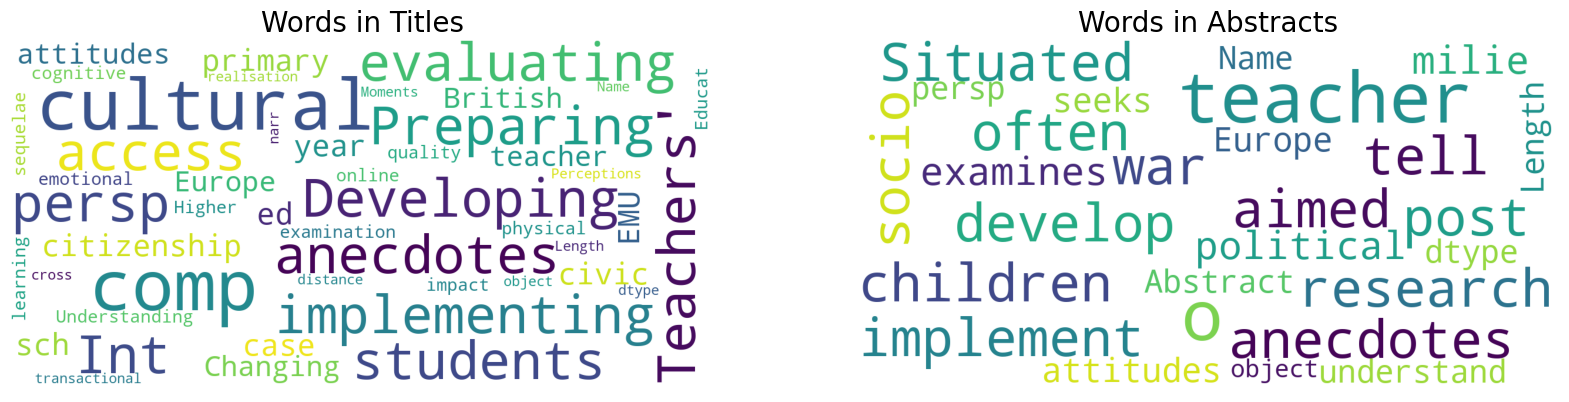

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

bp.show_wordcloud(df_subset['Title'], stopwords, ax=axs[0], title='Words in Titles')
bp.show_wordcloud(df_subset['Abstract'], stopwords, ax=axs[1], title='Words in Abstracts')

In [11]:
df_wide = pd.pivot(df_plot, index='words', columns='Year', values='counts')

df_wide = df_wide.fillna(0)

df_wide.head()

# Then I wanted to follow this: https://github.com/PetrKorab/Animated-Word-Cloud-in-Economics
# But I've hit a dead end because I can't install SWIG without running into compatibility issues
# required to: import framework

Year      2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  \
words                                                                        
05         0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
1          1.0   1.0   1.0   1.0   2.0   1.0   1.0   4.0   1.0   4.0   3.0   
10         0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
10001200   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1011       0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   

Year      2011  2012  2013  2014  2015  2016  2017  2018  2019  
words                                                           
05         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1          1.0   3.0   4.0   4.0   0.0   2.0   2.0   4.0   0.0  
10         1.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0  
10001200   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1011       0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0

In [12]:
df_plot.head()

Year        words  counts  total_publications_that_year  \
0  2000    malaysian       6                           423   
1  2000         name       1                           423   
2  2000  musicmaking       1                           423   
3  2000   meditation       1                           423   
4  2000         meet       1                           423   

   cumulative_pubs_over_time  cumulative_word_counts  \
0                        423                       6   
1                        423                       1   
2                        423                       1   
3                        423                       1   
4                        423                       1   

   relative_frequency_of_word  relative_counts_that_year  rolling_average  
0                    1.418440                   1.418440         1.418440  
1                    0.236407                   0.236407         0.236407  
2                    0.236407                   0.236407         0.236407  
3                    0.236407                   0.236407         0.236407  
4                    0.236407                   0.236407         0.236407

In [13]:
def plotly_animation2(df, n_appearances_threshold=50, n_words = 25, by_variance=True):
    """Plot animated bar chart using plotly.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with data to be plotted.
    n_appearances_threshold : int, optional
        Number of times a word must have appeared to be included 
    n_words : int, optional
        Maximum number of words to be plotted.
    by_variance : bool, optional
        If True, words are selected based on variance in percentage of appearances per year (
        those which change the most over time selected). Else by the total number of appearances.
    Returns
    -------
    plotly.graph_objects.Figure
        Animated bar chart.
    """
    import pandas as pd
    import plotly.express as px

    # Remove words that appear less than n_appearances_threshold times
    keep_words = df.loc[df['cumulative_word_counts'] >= n_appearances_threshold, 'words']
    if len(keep_words) == 0:
        # error message if no words meet the threshold
        raise ValueError('No words meet the threshold of {} appearances, try reducing'.format(n_appearances_threshold))
    df = df.loc[df['words'].isin(keep_words) ]

    if by_variance: 
        # Get the words with the highest variance in ratio of appearances
        top_words = df.groupby('words')['relative_frequency_of_word'].var().sort_values(ascending=False).head(n_words).index
    else: 
        # Get the most popular unique words (n_words)
        top_words = df.groupby('words')['counts'].sum().sort_values(ascending=False).head(n_words).index

    range_max = max(df['relative_frequency_of_word'])

    #df['key'] = df.groupby(['Year','words']).cumcount()
    df = pd.pivot_table(df, index='Year', columns=['words'], values='relative_frequency_of_word')
    df = df.stack(level=[0], dropna=False).reset_index()
    df.columns=['Year', 'words', 'ratio']

    df = df.loc[df['words'].isin(top_words)]
    df['words'] = df['words'].astype('category')
    df['words'] = df['words'].cat.reorder_categories(top_words)

    # Plotting the data
    fig = px.bar(df, x="words", y="ratio",  animation_frame="Year", range_y=[0, range_max])

    fig.update_layout(xaxis={'title': 'Word', 'visible': True, 'showticklabels': True}, yaxis={'title': 'Ratio'})
    fig.update_xaxes(categoryorder='array', categoryarray= top_words)

    return fig

In [14]:
plotly_animation2(df_plot, n_appearances_threshold=5, by_variance=False)

In [15]:
plotly_animation2(df_plot, n_appearances_threshold=5, by_variance=True)

In [16]:
df_plot.head()

Year        words  counts  total_publications_that_year  \
0  2000    malaysian       6                           423   
1  2000         name       1                           423   
2  2000  musicmaking       1                           423   
3  2000   meditation       1                           423   
4  2000         meet       1                           423   

   cumulative_pubs_over_time  cumulative_word_counts  \
0                        423                       6   
1                        423                       1   
2                        423                       1   
3                        423                       1   
4                        423                       1   

   relative_frequency_of_word  relative_counts_that_year  rolling_average  
0                    1.418440                   1.418440         1.418440  
1                    0.236407                   0.236407         0.236407  
2                    0.236407                   0.236407         0.236407  
3                    0.236407                   0.236407         0.236407  
4                    0.236407                   0.236407         0.236407

In [17]:
#!pip install seaborn==0.12.2

In [18]:
import seaborn as sns

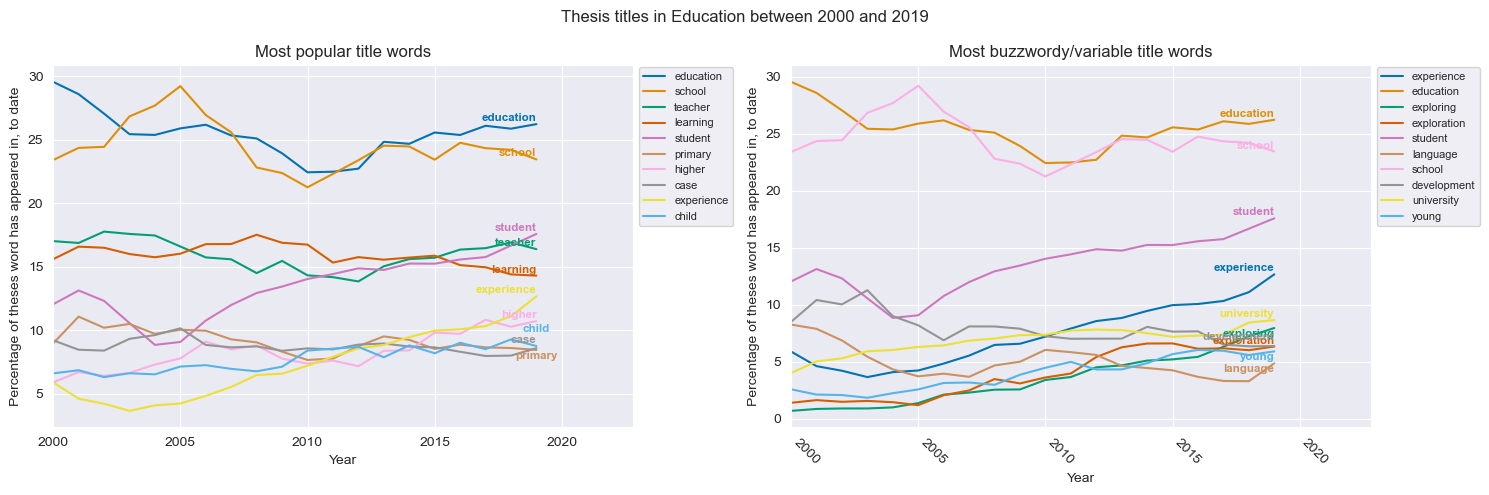

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.xticks(rotation=-45, ha='left') 

fig.suptitle('Thesis titles in Education between 2000 and 2019')


ax[0].set_title('Most popular title words')
bp.rolling_average(ax[0], df_plot, n_appearances_threshold=5, n_words = 10, by_variance=False)

ax[1].set_title('Most buzzwordy/variable title words')
bp.rolling_average(ax[1], df_plot, n_appearances_threshold=5, n_words = 10, by_variance=True)

fig.tight_layout()

In [22]:
subjects = df['Subject Discipline'].unique()
subjects = subjects[subjects != ' ']

print(subjects)

['Physical Sciences' 'Biological Sciences' 'Engineering & Technology'
 'Mathematics & Statistics' 'Agriculture & Veterinary Sciences'
 'Medicine & Health' 'Computer Science'
 'Philosophy, Psychology & Religious Studies'
 'Business & Administrative Studies' 'Education' 'Language & Literature'
 'Social, Economic & Political Studies'
 'Architecture, Building & Planning' 'History & Archaeology'
 'Creative Arts & Design' 'Law' 'Sport & Recreation'
 'Librarianship & Information Science' 'Music']


In [23]:
# Assign colours for each subject
from random import randint
from matplotlib import cm
from numpy import linspace
import seaborn as sns

color = sns.color_palette('colorblind', len(subjects) )

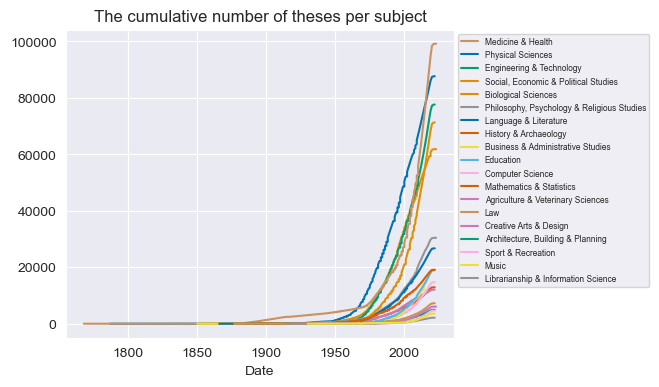

In [24]:
# Plot the number of theses per subject per year
df_subjects = df[['Subject Discipline', 'Date']].groupby(['Subject Discipline', 'Date']).size().reset_index(name='counts')
df_subjects = df_subjects[df_subjects['Subject Discipline'] != ' ']
df_subjects = df_subjects[df_subjects['Date'] != ' ']
df_subjects['Date'] = df_subjects['Date'].astype(int)

# order by date
df_subjects = df_subjects.sort_values(by=['Date'])

# cumulative counts for each subject
df_subjects['cumulative_counts'] = df_subjects.groupby('Subject Discipline')['counts'].cumsum()

# order by date
df_subjects = df_subjects.sort_values(by=['cumulative_counts'], ascending=False)

subs = list(df_subjects['Subject Discipline'].unique())

# plot the number of theses per subject per year
fig, ax = plt.subplots(figsize=(5, 4))
for subject in subjects:
    df_subjects[df_subjects['Subject Discipline'] == subject].plot(x='Date', y='cumulative_counts', ax=ax, label=subject, color=color[list(subjects).index(subject)])

# reorder the legend
handles,labels = ax.get_legend_handles_labels()
reorder = [labels.index(label) for label in subs]
handles = [handles[i] for i in reorder]
labels = [labels[i] for i in reorder]
plt.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 6})
plt.title('The cumulative number of theses per subject')
plt.show()

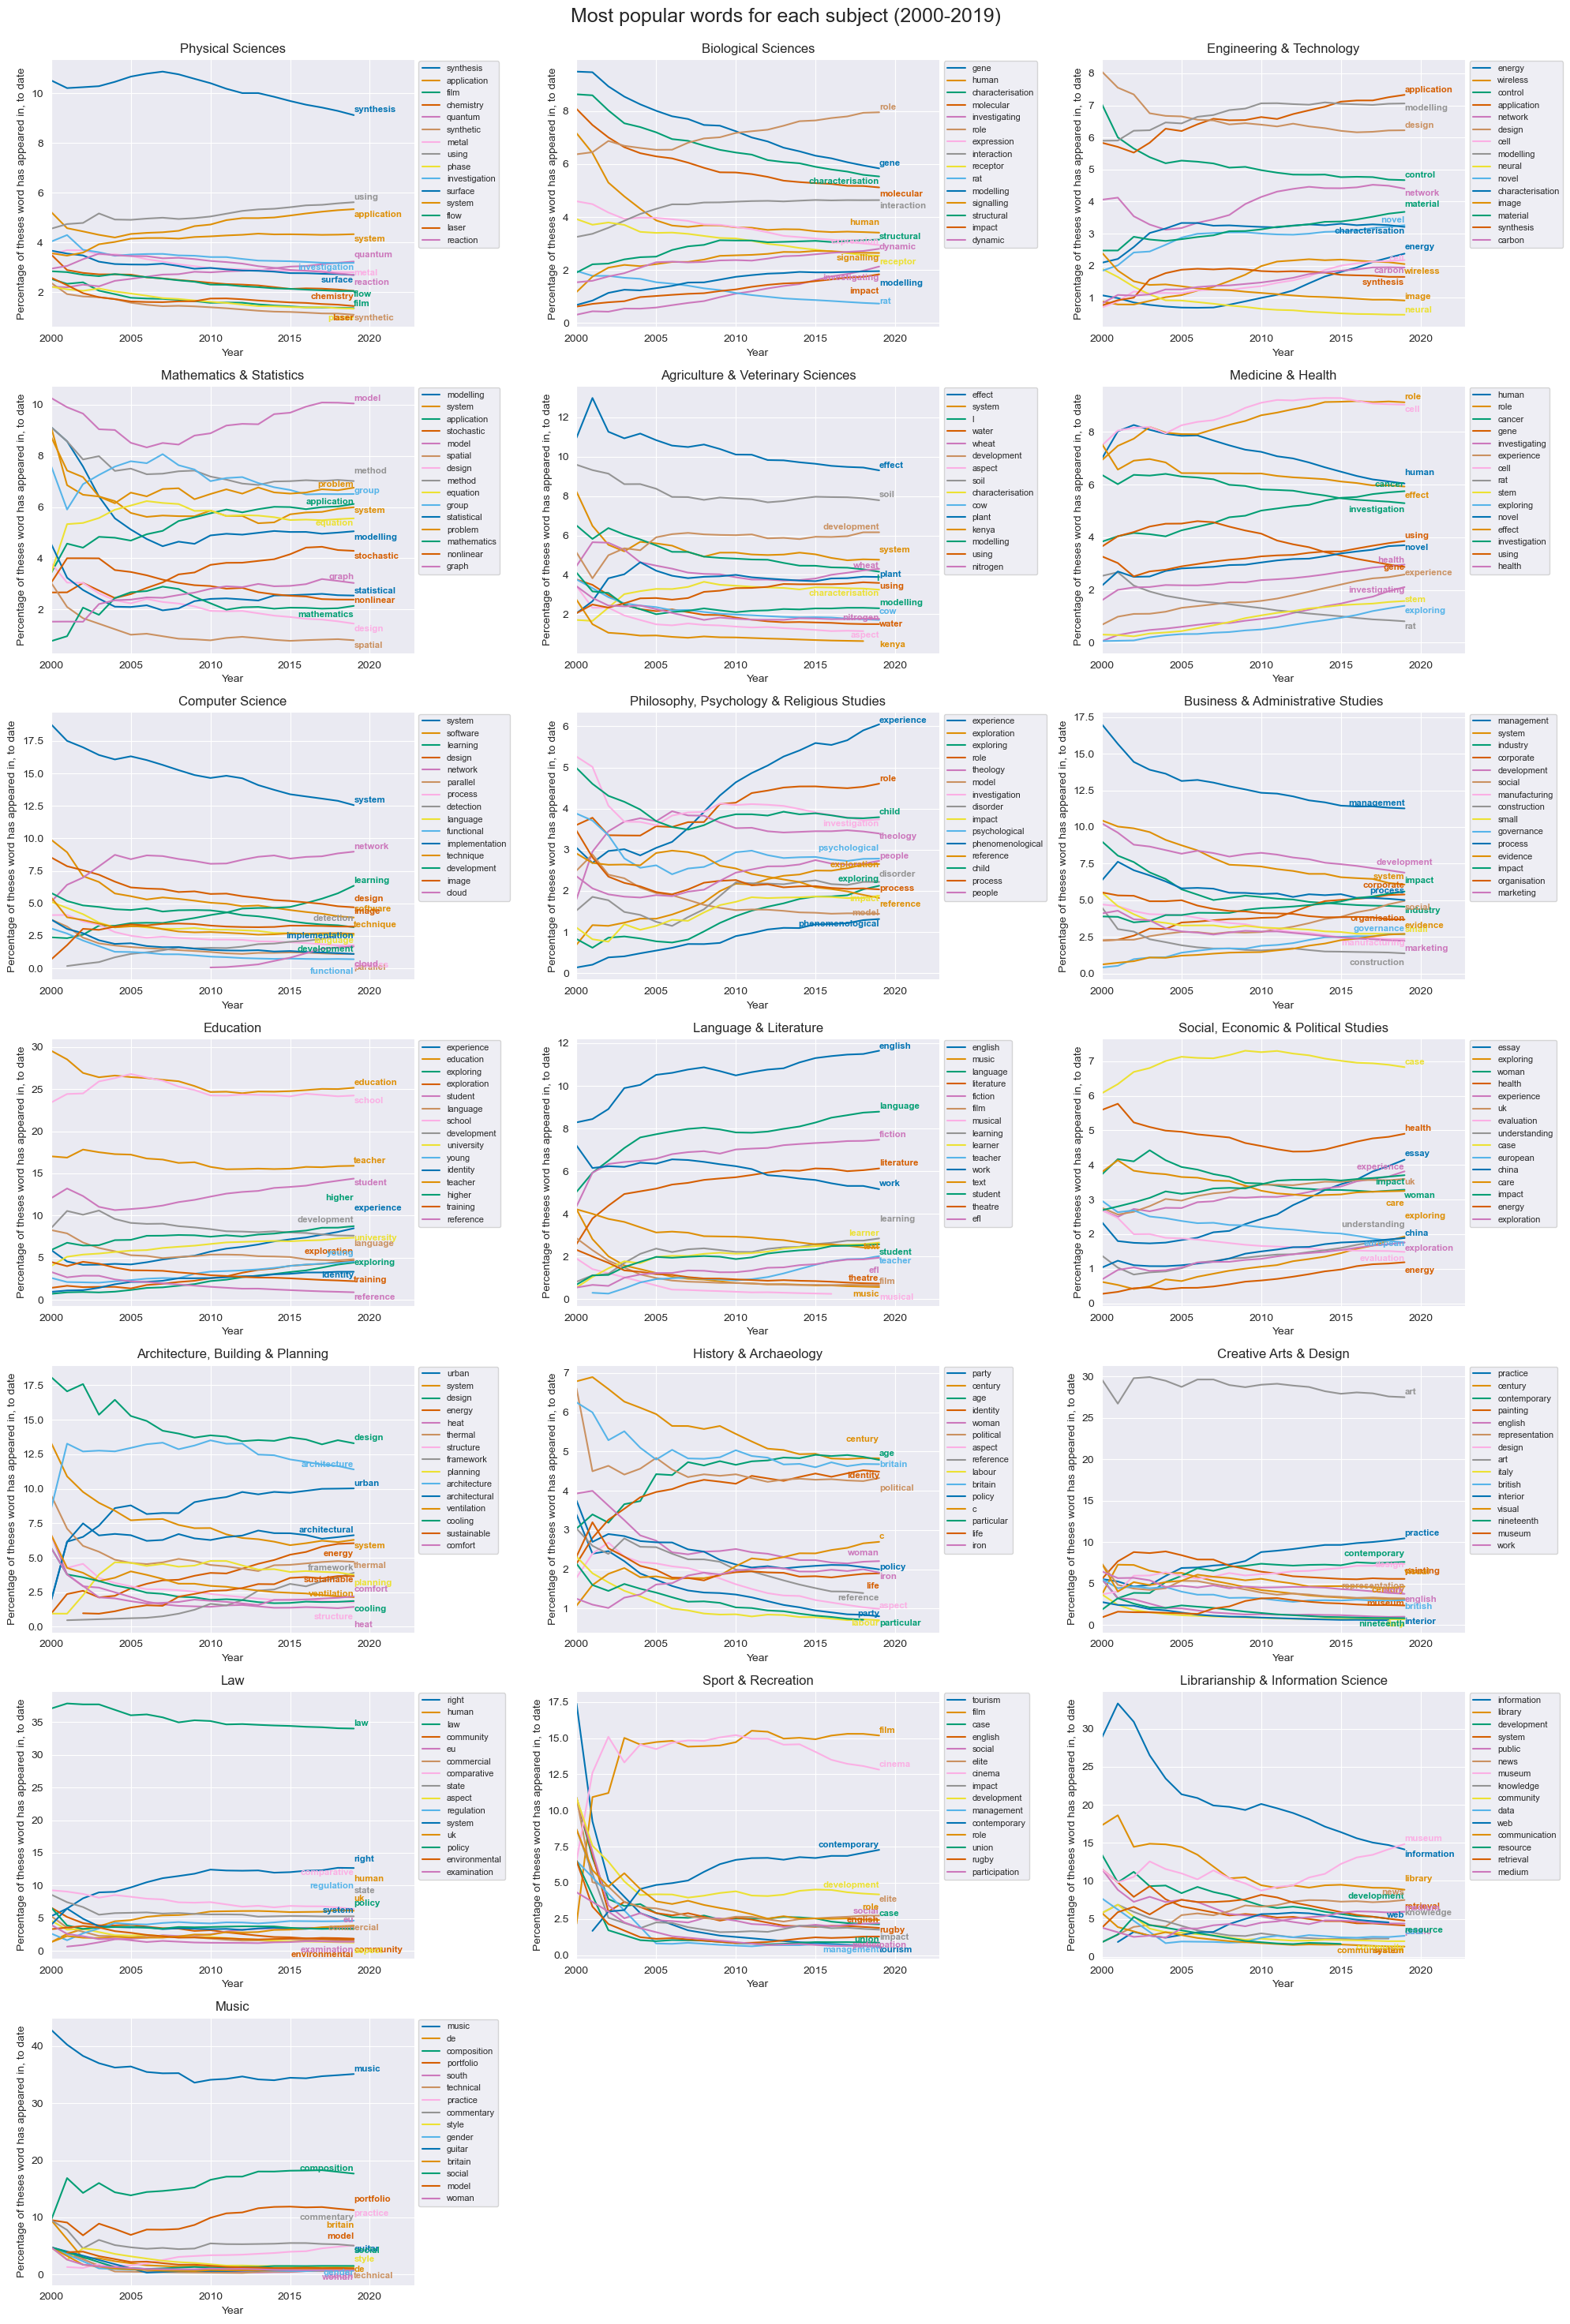

In [25]:
# This cell takes a while to run (~16secs for 2000-2019)

fig = plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5, left=0, right=2.4)


for i in range(len(subjects)):
    subject = subjects[i]
    df_subset = bp.filter_data(df, subjects=[subject], years=[2000, 2019])

    df_plot = preprocess_data3(df_subset, stop_words=list(stopwords), word_column='Title')
    ax = plt.subplot(7, 3, i + 1)

    ax.set_title(subject)
    bp.line_plot_seaborn(ax, df_plot, n_appearances_threshold=20, n_words=15, by_variance=True)

fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Most popular words for each subject (2000-2019)", fontsize=18)
plt.show()

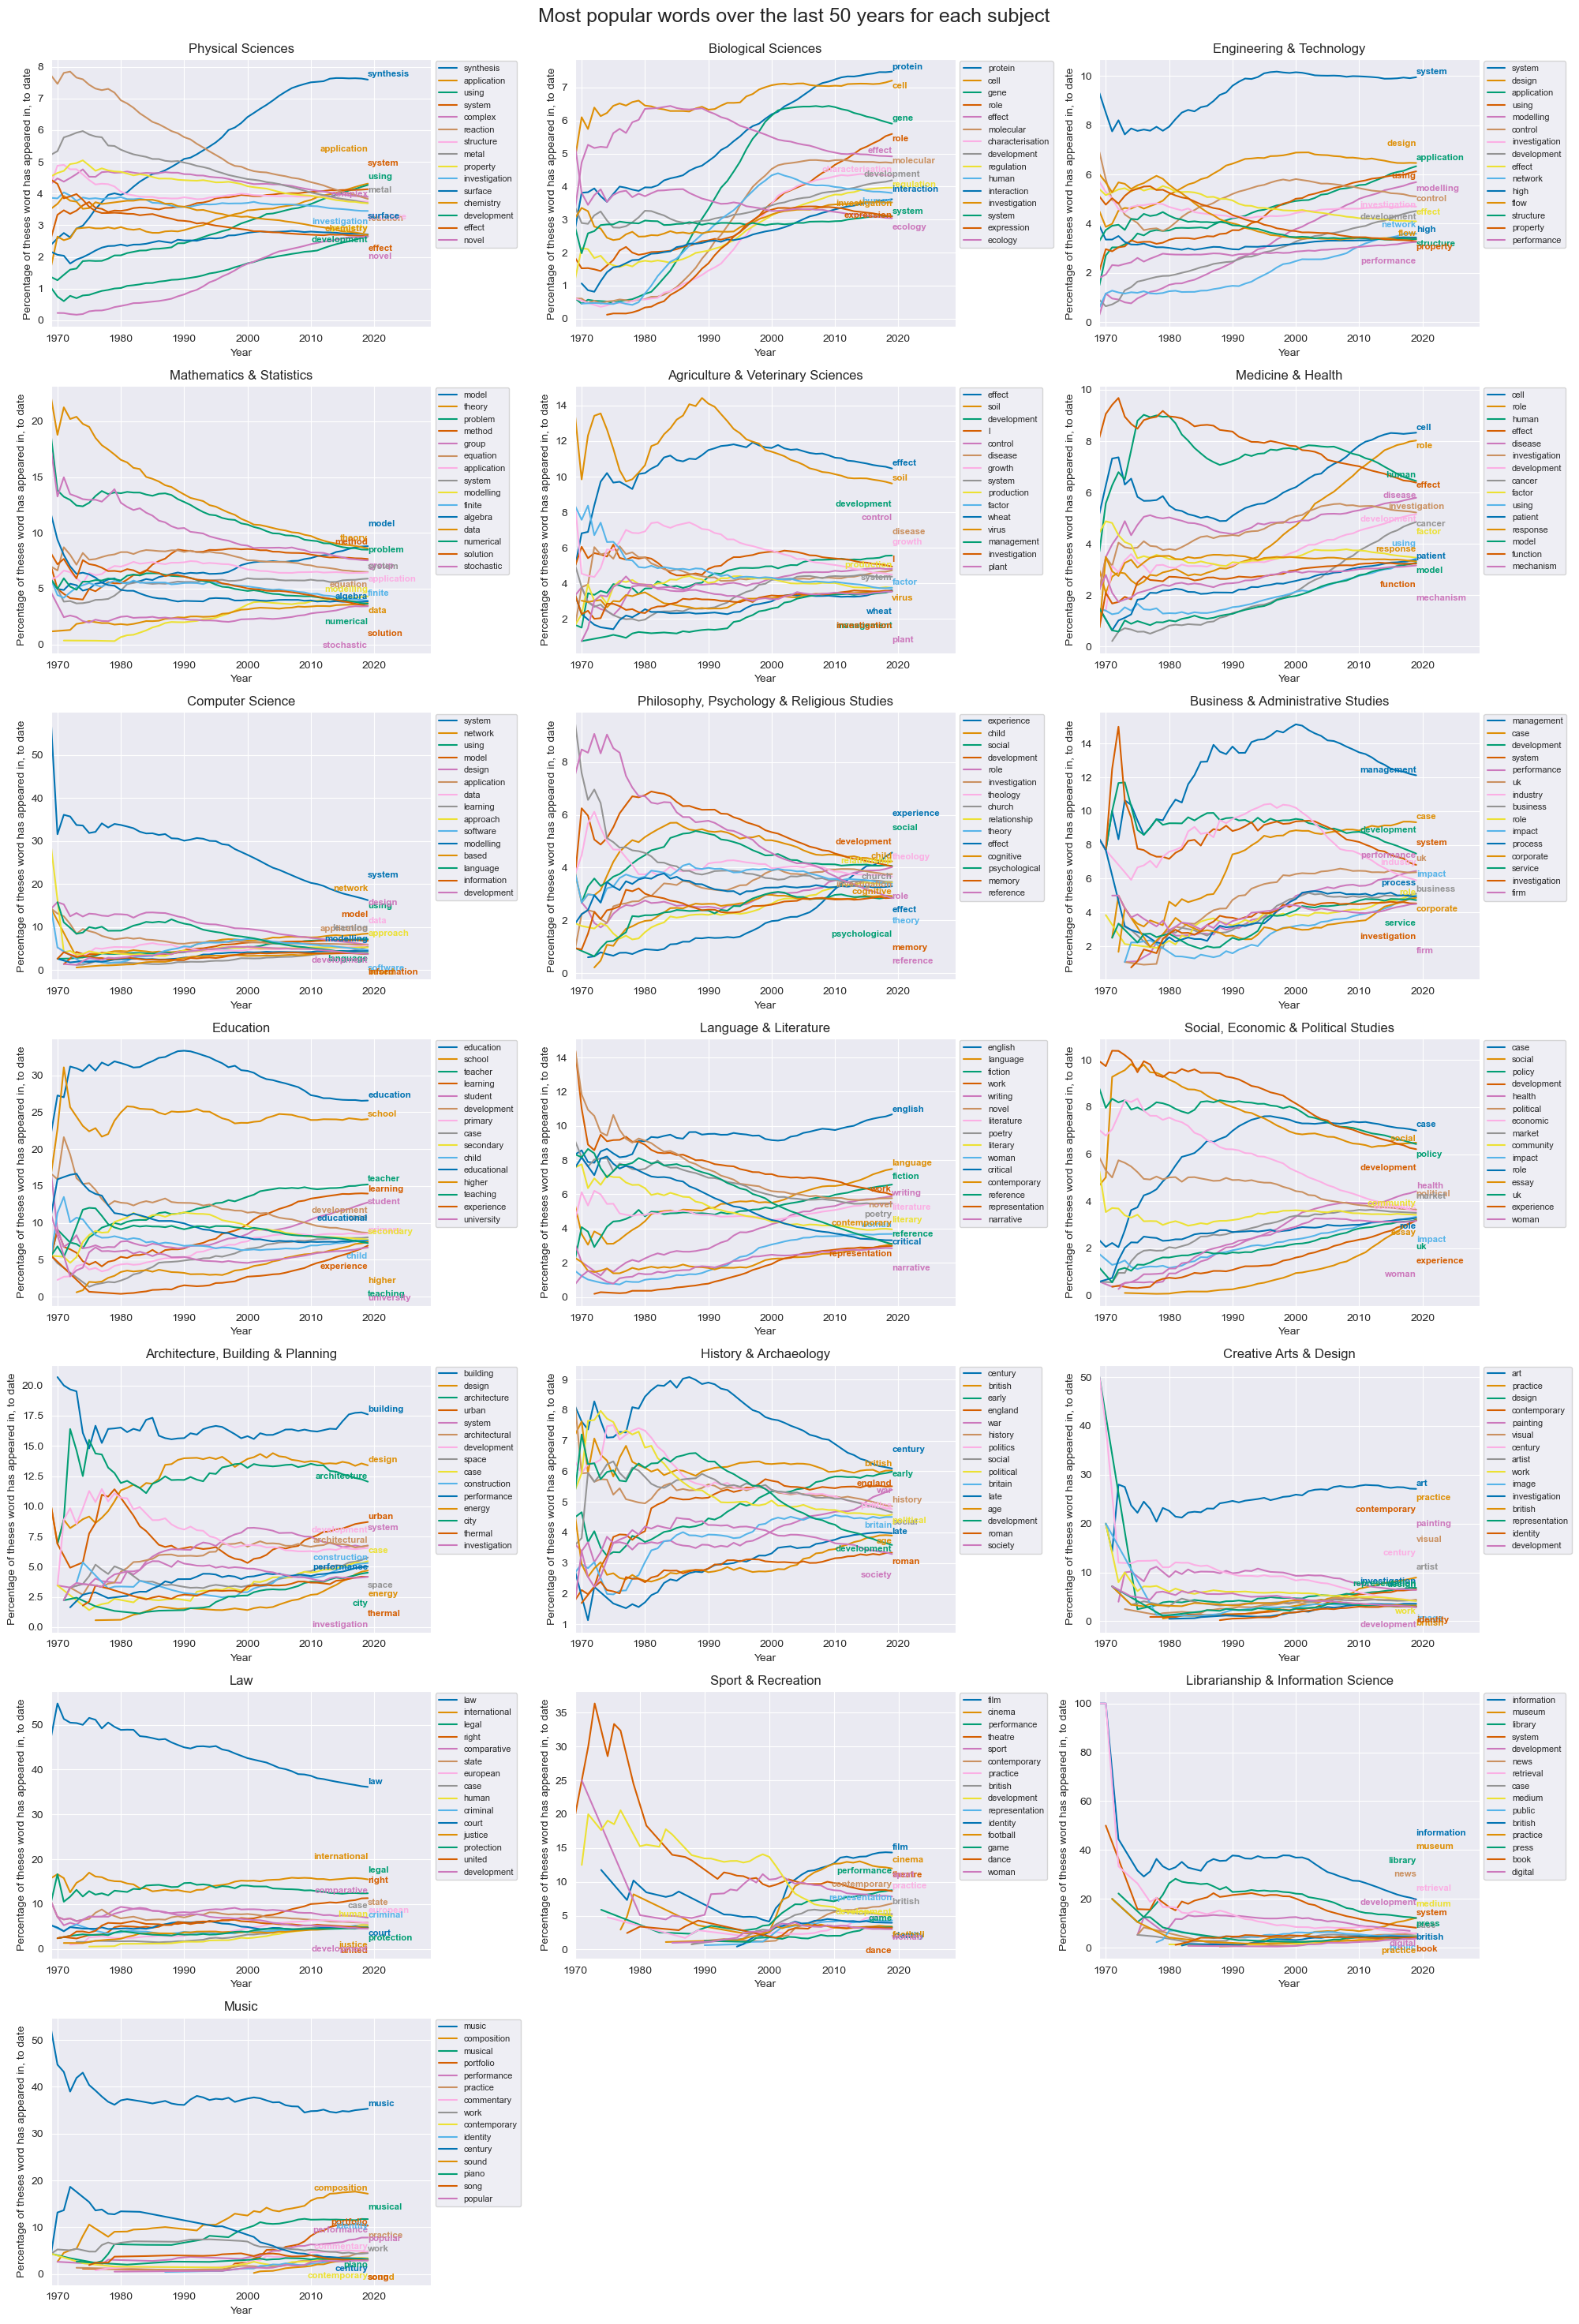

In [26]:
# This cell takes a while to run (~16secs for 2000-2019)

fig = plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5, left=0, right=2.4)


for i in range(len(subjects)):
    subject = subjects[i]
    df_subset = bp.filter_data(df, subjects=[subject], years=[1969, 2019])

    df_plot = preprocess_data3(df_subset, stop_words=list(stopwords), word_column='Title')
    ax = plt.subplot(7, 3, i + 1)

    ax.set_title(subject)
    bp.line_plot_seaborn(ax, df_plot, n_appearances_threshold=20, n_words=15, by_variance=False)

fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Most popular words over the last 50 years for each subject", fontsize=18)
plt.show()

In [ ]:
# This cell takes a while to run (~16secs for 2000-2019)

fig = plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5, left=0, right=2.4)


for i in range(len(subjects)):
    subject = subjects[i]
    df_subset = bp.filter_data(df, subjects=[subject], years=[2000, 2019])

    df_plot = preprocess_data3(df_subset, stop_words=list(stopwords), word_column='Title')
    ax = plt.subplot(7, 3, i + 1)

    ax.set_title(subject)
    bp.rolling_average(ax, df_plot, n_appearances_threshold=20, n_words=15, by_variance=False)

fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Rolling average percentage of most popular words for each subject (2000-2019)", fontsize=18)
plt.show()

In [ ]:
df_subset = bp.filter_data(df, subjects=['Computer Science'], years=[1990, 2019])
df_plot = preprocess_data3(df_subset, stop_words=list(stopwords), word_column='Title')

# remove system words
#df_plot = df_plot[~df_plot['words'].isin(['system', 'systems'])]

# get words which have higher relative frequency in 2019 than in 1990
growing_words = []
decreasing_words = []
for word in df_plot['words'].unique():
    df_word = df_plot[df_plot['words'] == word]
    last_val = df_word.loc[df_word['Year'] == df_word['Year'].max(), 'rolling_average'].values[0]
    first_val = df_word.loc[df_word['Year'] == df_word['Year'].min(), 'rolling_average'].values[0]
    if last_val >= first_val:
        growing_words.append(word)
    else:
        decreasing_words.append(word)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].set_title("Words which have increasing in popularity")
ax[1].set_title("Words which have decreasing in popularity")
bp.rolling_average(ax[0], df=df_plot.loc[df_plot['words'].isin(growing_words)], n_appearances_threshold=1, n_words=15, by_variance=True)
bp.rolling_average(ax[1], df=df_plot.loc[df_plot['words'].isin(decreasing_words)], n_appearances_threshold=1, n_words=15, by_variance=True)

# create a dictionary of dates
dates = {"Deep learning, Azure": 2010, "Neural nets": 1990, "RF&SVM": 1995, "MNIST": 1998}

for invention in dates.keys():
    ax[0].axvline(x=dates[invention], color='grey', linestyle='--', linewidth=0.5)
    ax[0].text(x=dates[invention]+0.5, y=df_plot.loc[df_plot['words'].isin(growing_words), 'relative_frequency_of_word'].max(), 
            s=invention, color='grey', verticalalignment='top', fontsize=8)


fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Trend of most popular terms in computational sciences as new technologies emerge", fontsize=12)
plt.show()

---

# Concluding Remarks

Here we have explored the gender breakdown

## Known Issues

- Here we are only including authors who provide first names. However women are more likely to initialize their names to mask gender. Additionally, this ratio varies between disciplines. 

- Some names not found by `gender_guesser`

- When counting, some names may not be unique (e.g. David Jones supervises > 50 students), however these may be multiple david jones'. Solution might be to group by institution but we dont necessarily know the supervisor inst. only the student ones. 

- Some supervisors I suspect are incorrectly assigned (especially for those with > 11)

- Assuming nobofy changes there name


## Data set not complete

- We have found anecdotal examples (Isabel's supervisor for example)



## To Do
- [ ] Try predicting gender with [nltk](https://www.geeksforgeeks.org/python-gender-identification-by-name-using-nltk/)
- [ ] Think about how yo handle non-unique names



- [ ] Could we use the abstract NLP to determine whether supervisors with same name are same person? 



- [ ] supervisor disambigation from abstract similarity? 


Author/supervisor disambigation

- [ ] does Jack Good student  == Jack Good supervisor

- [ ] cut-off on year (PhD thesis year should be before supervision year) and within in a realistic lifetime

- [ ] Then text similarity embedding comparison (see the slack channel for starting point) - see how similar theses abstracts/titles are (ignore those below a certain threshold). Then we should get a score for how likely people are to be the same person